This is a notebook with an example of the simulations carried out in https://arxiv.org/abs/2312.17146. We will use the Hydrogen molecule for this example.

In [1]:
#import libraries
import tequila as tq
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
#initialize a list of bond-lengths we will consider here
equilibrium_bl = 0.741
bond_lengths = [0.601, 0.741, 0.881]
bond_lengths.extend([i*0.5 for i in range(1,9)])
bond_lengths.sort()

print("We are considering the following configurations:", bond_lengths)

We are considering the following configurations: [0.5, 0.601, 0.741, 0.881, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]


In [3]:
#get Hamiltonian and commuting groups for a molecular configuration

Hamiltonians = []
Graph_circuits = []

for bond in bond_lengths:
    file = open("../Hamiltonians/H2/H2_Hamiltonian_for_bond_length_{0}.pickle".format(bond),'rb')
    mol_Ham = pickle.load(file)
    file.close()
    
    print("The Hamiltonian at bond length - {0} - is: {1}".format(bond, mol_Ham))
    
    file = open("../groups_and_circuits/H2/H2_groups_and_circuits_for_bond_length_{0}.pickle".format(bond),'rb')
    groups, circuits = pickle.load(file)
    file.close()
    
    print("The groups at bond length - {0} - is:".format(bond))
    print("\t Commuting groups:", groups)
    for circ in circuits:
        print("Clifford Circuit:", tq.draw(circ, backend="cirq"))
        ### The CZ-gate is represented as H-CX-H
              
    Hamiltonians.append(mol_Ham)
    Graph_circuits.append(circuits)

The Hamiltonian at bond length - 0.5 - is: +0.3798+0.2139Z(0)+0.2139Z(0)Z(1)-0.3691Z(2)-0.3691Z(1)Z(2)Z(3)+0.1799Z(1)+0.0422Y(0)Z(1)Y(2)Z(3)+0.0422X(0)Z(1)X(2)+0.0422X(0)Z(1)X(2)Z(3)+0.0422Y(0)Z(1)Y(2)+0.1346Z(0)Z(2)+0.1768Z(0)Z(1)Z(2)Z(3)+0.1768Z(0)Z(1)Z(2)+0.1346Z(0)Z(2)Z(3)+0.1862Z(1)Z(3)
The groups at bond length - 0.5 - is:
	 Commuting groups: [[+0.3798, +0.2139Z(0), +0.2139Z(0)Z(1), -0.3691Z(2), -0.3691Z(1)Z(2)Z(3), +0.1799Z(1), +0.1346Z(0)Z(2), +0.1768Z(0)Z(1)Z(2)Z(3), +0.1768Z(0)Z(1)Z(2), +0.1346Z(0)Z(2)Z(3), +0.1862Z(1)Z(3)], [+0.0422Y(0)Z(1)Y(2)Z(3), +0.0422X(0)Z(1)X(2), +0.0422X(0)Z(1)X(2)Z(3), +0.0422Y(0)Z(1)Y(2)]]
circuit: 

Clifford Circuit: None
circuit: 
H(target=(0,))
H(target=(1,))
H(target=(2,))
H(target=(3,))
H(target=(1,))
X(target=(1,), control=(0,))
H(target=(1,))
H(target=(2,))
X(target=(2,), control=(0,))
H(target=(2,))
H(target=(3,))
H(target=(2,))
Z(target=(0,))
Z(target=(2,))
Z(target=(3,))

Clifford Circuit: None
The Hamiltonian at bond length - 0.601 - is:

In [4]:
#let's calculate the ground state energies of the molecule at the different configurations
FCI_eners = []

for Ham in Hamiltonians:
    v,vv = np.linalg.eigh(Ham.to_matrix())
    FCI_eners.append(v[0])
    
print("The exact ground state energies of the molecules are:", FCI_eners)

The exact ground state energies of the molecules are: [-1.0551597946880173, -1.1166462657704586, -1.1372744055258712, -1.1237206708647083, -1.1011503301329568, -0.9981493533579184, -0.9486411121296494, -0.9360549199436622, -0.9336318445559841, -0.9332284055492808, -0.9331713618435846]


In [5]:
#Calculating HF energies
num_qubits = 4

HF_ener = []
for Ham in Hamiltonians:
    #simulating reference state-prep circuit (in BK basis)
    ref = tq.QCircuit()    
    ref += tq.gates.X(0)
    
    Exp = tq.ExpectationValue(U=ref, H= Ham)
    energy = tq.simulate(Exp, backend="qulacs")
    #print(energy)
    HF_ener.append(energy)
    
    
print("Hartree-Fock energy:", HF_ener)

Hartree-Fock energy: [-1.0429962747511712, -1.1014552070447619, -1.1167061372172085, -1.0961661385920694, -1.0661086491853156, -0.9108735543822686, -0.7837926540830397, -0.7029435995786047, -0.6560482510473122, -0.6298201100573617, -0.6148699739991873]


In [6]:
g_seed = 1

def random_number(num_param):
    """
    This function calls the numpy.random.randn function with
    a new seed every time, and returns the values
    """
    global g_seed
    rand_state = np.random.RandomState(seed = g_seed)
    g_seed += int(np.abs(np.random.randn(1)[0]*10) + 1)
    return rand_state.randn(num_param)

In [7]:
#Now we construct the H-GSA ansatz and carry optimization
mean_vqe_eners = []
std_vqe_eners = []

mean_vqe_errors = []
vqe_errors_min = []
vqe_errors_max = []

for index, (Ham, circuits) in enumerate(zip(Hamiltonians, Graph_circuits)):
    
    #construct the CCA
    HGSA = tq.QCircuit()
    
    #Add the reference state-prep circuit (in BK basis)
    HGSA += tq.gates.X(0)
    
    #only considering the non-empty circuits
    for i, cir in enumerate(circuits[1:]):
       
        #Add the Clifford circuit
        HGSA += cir.dagger()
        
        #Add the single qubit rotation layer
        for qubit in range(num_qubits):
            var_1 = tq.Variable("th_q{0}_l{1}".format(qubit, i))
            var_2 = tq.Variable("ph_q{0}_l{1}".format(qubit, i))
            var_3 = tq.Variable("la_q{0}_l{1}".format(qubit, i))
            
            HGSA += tq.gates.Rz(var_1, qubit)                
            HGSA += tq.gates.Ry(var_2, qubit)
            HGSA += tq.gates.Rz(var_3, qubit)                
            HGSA += tq.gates.Ry(-1*var_2, qubit)
            HGSA += tq.gates.Rz(-1*var_1, qubit)
        
        #Add the Clifford circuit inverse
        HGSA += cir
    
    energies = []
    errors = []
    num_samples = 5
    for samp in range(num_samples):
        initial_values = {}

        for var_ in HGSA.extract_variables():
            if "th" in str(var_) or "ph" in str(var_):
                initial_values[var_] = random_number(1)[0]
            else:
                initial_values[var_] = 1e-6
        
    
        Exp = tq.ExpectationValue(U=HGSA, H= Ham)
        result = tq.minimize(objective=Exp,initial_values = initial_values, tol= 1e-6, method="bfgs" ,backend="qulacs", silent="True")
        energy = result.energy
        #print(energy)
        energies.append(energy)
        errors.append(energy - FCI_eners[index])
    
    mean_vqe_eners.append(np.mean(energies))
    std_vqe_eners.append(np.std(energies))
    
    mean_vqe_errors.append(np.mean(errors))
    vqe_errors_min.append(np.min(errors))
    vqe_errors_max.append(np.max(errors))
        
    
print("Energy from VQE with HGSA:", mean_vqe_eners)

Energy from VQE with HGSA: [-1.0551597946876647, -1.1166462657698542, -1.137274405525501, -1.123720670864302, -1.1011503301324441, -0.9981493533544645, -0.9486411121289813, -0.9360549199353754, -0.9336318445558953, -0.9332284055489914, -0.9331713618432609]


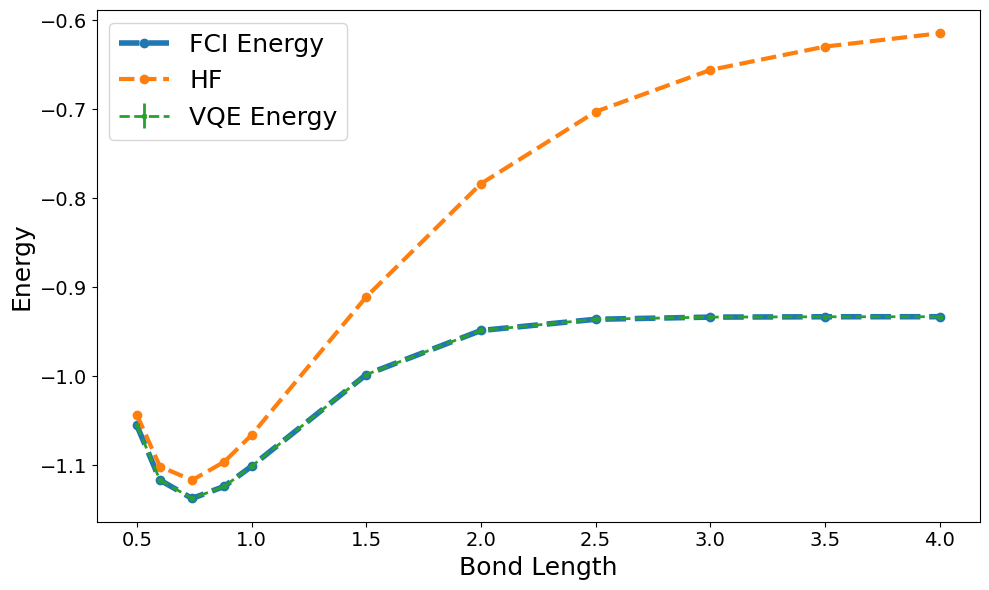

In [8]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.rc('legend',fontsize=18)
plt.plot(bond_lengths, FCI_eners, marker="o", markersize=6, linestyle="--", linewidth=4, label="FCI Energy")
plt.plot(bond_lengths, HF_ener, marker="o", markersize=6, linestyle="--", linewidth=3, label="HF")
plt.errorbar(bond_lengths, mean_vqe_eners, std_vqe_eners, marker="X", markersize=3, linestyle="--", linewidth=2, label="VQE Energy")
plt.xlabel('Bond Length', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

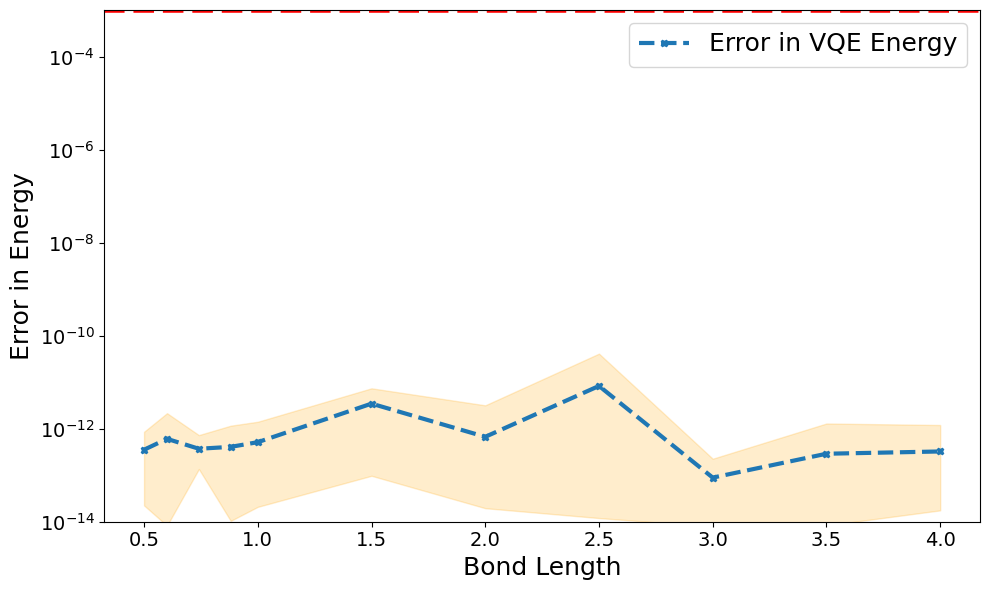

In [9]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.rc('legend',fontsize=18)
plt.ylim(1e-14, 1e-3)
plt.yscale("log")
plt.axhline(y=1e-3, color='r', linestyle='--',linewidth=4)
plt.plot(bond_lengths, mean_vqe_errors, marker="X", markersize=5, linestyle="--", linewidth=3, label="Error in VQE Energy")
plt.fill_between(bond_lengths, vqe_errors_min, vqe_errors_max, alpha=0.2, color ='orange')
plt.xlabel('Bond Length', fontsize=18)
plt.ylabel('Error in Energy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()